In [80]:
import numpy as np
import pandas as pd

# Define a routine to calculate a few basic stats for given data
def basic_data_stats(data):
    nrows = data.shape[0]
    ncols = data.shape[1]
    print "nrows : ncols = ", nrows, " : ", ncols    
    
    descriptive = pd.DataFrame()
    descriptive['mean'] = data.mean()
    descriptive['sd'] = data.std()
    descriptive['min'] = data.min()
    descriptive['max'] = data.max()
    descriptive['mad'] = data.mad()
    descriptive['kurt'] = data.kurt()
    descriptive['nans'] = nrows - data.count()
    pd.set_option('precision',4)
    pd.set_option('display.width', 100)
    print descriptive

# import the features and lables data from csv formatted files. These files have
# 3 indexing columns, which are "city" "year" and "week_of_year"
dengue_features_train = pd.read_csv("dengue_features_train.csv", index_col=[0,1,2])
dengue_labels_train = pd.read_csv("dengue_labels_train.csv", index_col=[0,1,2])

# the features data also has a "week_start_date" column, which is redundant so we remove it.
dengue_features_train.drop('week_start_date', axis=1, inplace=True)
    
# separate the data for the two cities, so we can model them separately
# get the San Juan data first
sj_features_train = dengue_features_train.loc['sj']
sj_labels_train = dengue_labels_train.loc['sj']

# now the Iquitos data
iq_features_train = dengue_features_train.loc['iq']
iq_labels_train = dengue_labels_train.loc['iq']

# print the basic stats for the reported dengue cases.
print "Basic Stats for San Juan Dengue Cases"
basic_data_stats(sj_labels_train)
print "Basic Stats for Iquitos Dengue Cases"
basic_data_stats(iq_labels_train)


Basic Stats for San Juan Dengue Cases
nrows : ncols =  936  :  1
                mean       sd  min  max      mad     kurt  nans
total_cases  34.1806  51.3814    0  461  28.3521  25.3721     0
Basic Stats for Iquitos Dengue Cases
nrows : ncols =  520  :  1
               mean       sd  min  max    mad     kurt  nans
total_cases  7.5654  10.7655    0  116  6.684  26.7361     0


In [81]:
# check for missing data in the features
nrows = sj_features_train.shape[0]
nans = nrows - sj_features_train.count()
print "Nans in San Juan Features\n", nans

nrows = iq_features_train.shape[0]
nans = nrows - iq_features_train.count()
print "\n\nNans in Iquitos Features\n", nans


Nans in San Juan Features
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_min_temp_c                         6
station_precip_mm                          6
dtype: int64


Nans in Iquitos Features
ndvi_ne                           

In [82]:
# take a look at how the 4 measurments of vegitation cover are correlated
sj_veg_features = sj_features_train[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']]
feature_corrs = sj_veg_features.corr()
print feature_corrs

         ndvi_ne  ndvi_nw  ndvi_se  ndvi_sw
ndvi_ne   1.0000   0.6730   0.2340   0.1778
ndvi_nw   0.6730   1.0000   0.1963   0.2146
ndvi_se   0.2340   0.1963   1.0000   0.8214
ndvi_sw   0.1778   0.2146   0.8214   1.0000


In [83]:
# drop ndvi_ne as it has a lot of Nans
#sj_features_train.drop('ndvi_ne', axis=1, inplace=True)
del sj_features_train['ndvi_ne']

# interpolate missing values - but only for a single week
sj_features_train = sj_features_train.interpolate(limit=1, limit_direction='both')



In [84]:
# create time shifted features, so that the model can be based on measurements
# from the previous weeks, which we expect to be important.
def create_time_shifted_features(feature_data, max_history_depth=8, nans_for_unknown=True):
    # create an empty dataframe but with the same indexes
    new_features = feature_data[[]]
    # work through the columns of feature data
    for feature in feature_data.columns:
        if feature == 'weekno':
            continue
        # copy the feature data in the column
        data_col = feature_data[feature].values
        first_val = data_col[0]
        # now create time shifted versions of this data. We pad the data
        # at the beginning with Nans during model development, so we can
        # easily spot and cull these data points later. When we are preprocessing
        # data for real prediction scenarios we dont want to be throwing away these
        # data rows, so fill in by just repeating the first value in the columnm.
        for i in range(1, max_history_depth+1):
            if nans_for_unknown:
                data_col = np.insert(data_col, 0, np.nan)
            else:
                data_col = np.insert(data_col, 0, first_val)
            data_col = np.delete(data_col, -1)
            new_feat_name = feature + "_" + str(i) + "weeksago"
            new_features.loc[:,new_feat_name] = data_col
    return new_features

time_shifted_features = create_time_shifted_features(sj_features_train, max_history_depth=12, nans_for_unknown=True)
sj_features_train = sj_features_train.join(time_shifted_features)


In [85]:
# routine to remove data points which have incomplete data
def remove_incomplete_data(features, labels):
    # find out which rows have a full set of data
    without_nan = features.notnull().all(axis=1)

    # and cull any rows that do not have full data - note that we need to cull the labels too!
    full_features = features.loc[without_nan,:]
    full_labels = labels.loc[without_nan]
    return full_features, full_labels


# cull incomplete data rows and correpsonding labels
sj_features_train, sj_labels_train = remove_incomplete_data(sj_features_train, sj_labels_train)
print "full data rows left : ", sj_labels_train.shape[0]

full data rows left :  886


In [86]:
#   feature_label_corrs(data, labels) 
#   data : a DataFrame containing numeric feature data
#   labels: a Series containing the labels/outputs to find correlations against
def feature_label_corrs(data, labels):
    print "feature correlations to labels :\n"
    for feature in data.columns:
        feature_data = data[feature]
        correl = feature_data.corr(labels['total_cases'])
        print feature, " : ", correl

feature_label_corrs(sj_features_train, sj_labels_train)

feature correlations to labels :

ndvi_nw  :  0.0837848938958
ndvi_se  :  -0.00239225473452
ndvi_sw  :  -0.00259378315944
precipitation_amt_mm  :  0.0948840230002
reanalysis_air_temp_k  :  0.252200641644
reanalysis_avg_temp_k  :  0.245342329928
reanalysis_dew_point_temp_k  :  0.272340916861
reanalysis_max_air_temp_k  :  0.258929079855
reanalysis_min_air_temp_k  :  0.257289945884
reanalysis_precip_amt_kg_per_m2  :  0.145712076073
reanalysis_relative_humidity_percent  :  0.178731898483
reanalysis_sat_precip_amt_mm  :  0.0948840230002
reanalysis_specific_humidity_g_per_kg  :  0.280388305526
reanalysis_tdtr_k  :  -0.0612867199641
station_avg_temp_c  :  0.228926901122
station_diur_temp_rng_c  :  -0.0156703027984
station_max_temp_c  :  0.179569784361
station_min_temp_c  :  0.222107007752
station_precip_mm  :  0.0587139792888
ndvi_nw_1weeksago  :  0.0883430530986
ndvi_nw_2weeksago  :  0.0822212501667
ndvi_nw_3weeksago  :  0.0812055451374
ndvi_nw_4weeksago  :  0.0758533298908
ndvi_nw_5weeksago

In [87]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt

def find_best_dtr_params(features, labels):
    dtr = DecisionTreeRegressor(criterion='mae', max_depth=4, min_samples_split=10, random_state=0)

#   create our cross validation object. Basically try to split into folds that are each 2 years long    
    nrows = features.shape[0]
    years = np.uint32(np.fix(nrows / (52*2)))
    crossval = KFold(n_splits = years)

    grid = GridSearchCV(dtr, {'max_depth':[3,4,6,10], 'min_samples_split':[2, 5, 10, 20]},
                        iid=False, cv=crossval, n_jobs=8,verbose=1)

#    The grid search takes about 3 minutes per parameter combination    
    print "starting grid search"
    grid.fit(features, labels['total_cases'])
    print "best params : ", grid.best_params_
    
    clf = grid.best_estimator_
    print "feature_importances : ", clf.feature_importances_
    return clf


def find_best_boost_params(base_learner, features, labels):

#   cross validation strategy - It is important to have good separation (in time)
#   of training data and validation data. This is because data points that are
#   close together in time are highly correlated, so if we have training data that
#   is temporally close to validation data we risk leaking information from the
#   validation data into the model, leading to us not being able to spot overfitting.
#   So a simple Kfold cross validation without shuffling is probably the best.

#   select a base model
#    dtr = DecisionTreeRegressor(criterion='mae', max_depth=3, min_samples_split=2, random_state=0)
    boosted = AdaBoostRegressor(base_estimator=base_learner, n_estimators=50, learning_rate=1.0, random_state=0)
    
#   create our cross validation object. Basically try to split into folds that are each 2 years long    
    nrows = features.shape[0]
    years = np.uint32(np.fix(nrows / (52*2)))
    crossval = KFold(n_splits = years)
    grid = GridSearchCV(boosted, {'n_estimators':[10,20,40], 'learning_rate':[0.02, 0.1, 0.3, 1.0]},
                        iid=False, cv=crossval, n_jobs=8, verbose=1)

#    The grid search takes about 3 minutes per parameter combination    
    print "starting grid search"
    grid.fit(features, labels['total_cases'])
    print "best params : ", grid.best_params_
    
#
    clf = grid.best_estimator_
    print "estimator weights : ", clf.estimator_weights_
    return clf

def test_estimator(clf, features, labels):
    nrows = features.shape[0]
    nfeatures = features.shape[1]
    n_train = np.uint32(np.fix(nrows * 0.7))
    feat_train_set = features[:n_train]
    feat_val_set = features.tail(n=(nrows-n_train))

    labels_train_set = labels['total_cases'].head(n=n_train)
    labels_val_set = labels['total_cases'].tail(n=(nrows-n_train))

    years = np.uint32(np.fix(nrows / (52*2)))
    crossval = KFold(n_splits = years)
    scores = cross_val_score(clf, features, y=labels['total_cases'], groups=None,
                scoring='neg_mean_absolute_error', cv=crossval, n_jobs=8, verbose=1, fit_params=None)
    print "cross_val scores : ", scores

    clf.fit(feat_train_set, labels_train_set)
    predicted_values = clf.predict(feat_val_set)
    np.clip(predicted_values, 0, 999999, out=predicted_values)
    np.rint(predicted_values, predicted_values)
    
    print "mae for val set: ", mean_absolute_error(labels_val_set, predicted_values)
    print "R2 for val set: ", r2_score(labels_val_set, predicted_values)

    predicted_values = clf.predict(feat_train_set)
    np.clip(predicted_values, 0, 999999, out=predicted_values)
    np.rint(predicted_values, predicted_values)
    print "mae for train set: ", mean_absolute_error(labels_train_set, predicted_values)
    print "R2 for train set: ", r2_score(labels_train_set, predicted_values)
    
    predicted_values = clf.predict(features)
    week = range(0, nrows)
    plt.figure(figsize=(14,6))
    plt.plot(week, predicted_values, 'r--', week, labels['total_cases'], 'b--')
    fig = plt.gcf()
    fig.set_size_inches(12,6,forward=True)
    plt.show()
    
    return clf


starting grid search
Fitting 8 folds for each of 16 candidates, totalling 128 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:   24.4s finished


best params :  {'min_samples_split': 2, 'max_depth': 3}
feature_importances :  [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.1022937   0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.8s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.7s finished


cross_val scores :  [-30.79279279 -17.80630631 -12.2972973  -41.9009009  -13.51351351
 -15.12612613 -18.64545455 -16.41818182]
mae for val set:  20.0488721805
R2 for val set:  -1.26701480604
mae for train set:  16.4306451613
R2 for train set:  0.471765101749


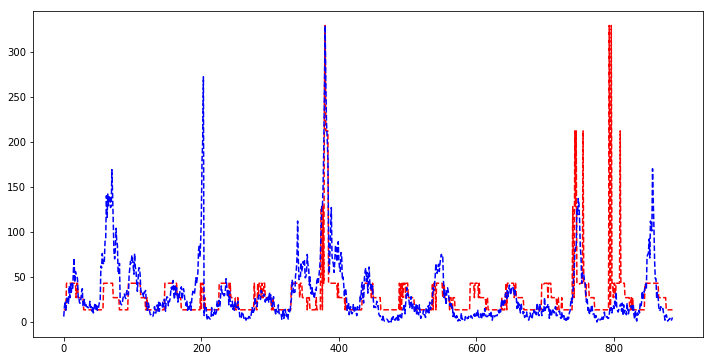

DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [88]:
sj_dtr = find_best_dtr_params(sj_features_train, sj_labels_train)
test_estimator(sj_dtr, sj_features_train, sj_labels_train)

In [89]:
sj_clf = find_best_boost_params(sj_dtr, sj_features_train, sj_labels_train)


starting grid search
Fitting 8 folds for each of 12 candidates, totalling 96 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   59.4s
[Parallel(n_jobs=8)]: Done  96 out of  96 | elapsed:  3.5min finished


best params :  {'n_estimators': 20, 'learning_rate': 0.02}
estimator weights :  [ 0.05769909  0.05621046  0.05539682  0.0531718   0.0551891   0.05452761
  0.05541909  0.05417536  0.05496308  0.05000359  0.05047836  0.05413013
  0.05482878  0.05146962  0.05198251  0.04960353  0.05350452  0.05292789
  0.04967558  0.05268089]


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   14.9s remaining:   44.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   20.7s finished


cross_val scores :  [-30.48198198 -17.38288288  -8.78828829 -42.1036036  -12.51351351
 -11.45945946 -14.65454545 -16.07272727]
mae for val set:  15.6015037594
R2 for val set:  0.22153725021
mae for train set:  16.5193548387
R2 for train set:  0.350366618514


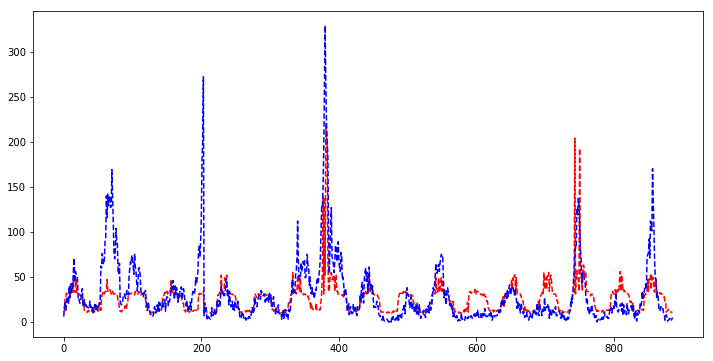

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best'),
         learning_rate=0.02, loss='linear', n_estimators=20,
         random_state=0)

In [90]:
test_estimator(sj_clf, sj_features_train, sj_labels_train)

In [91]:
# go through the same process with the Iquitos data
# the Iqitos data has fewer Nans, so dont drop any of the feature columns
# However the first 70 weeks look anomolously low, so I am going to remove
# those
iq_features_train = dengue_features_train.loc['iq']
iq_labels_train = dengue_labels_train.loc['iq']

features_train = iq_features_train.iloc[0:,:]
labels_train = iq_labels_train.iloc[0:]

# interpolate missing values - but only for a single week
features_train = features_train.interpolate(limit=1, limit_direction='both')

time_shifted_features = create_time_shifted_features(features_train, max_history_depth=12, nans_for_unknown=True)
features_train = features_train.join(time_shifted_features)

iq_features_train, iq_labels_train = remove_incomplete_data(features_train, labels_train)
print "full data rows left : ", features_train.shape[0]


full data rows left :  520


starting grid search
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:    9.9s finished


best params :  {'min_samples_split': 10, 'max_depth': 3}
feature_importances :  [ 0.          0.          0.          0.          0.          0.          0.
  0.37181996  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.09393346  0.          0.          0.          0.          0.
  0.          0.12133072  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.         

[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    4.0s finished


cross_val scores :  [-6.36666667 -6.6302521  -4.1092437  -8.03361345]
mae for val set:  8.22222222222
R2 for val set:  -0.798037418769
mae for train set:  3.88288288288
R2 for train set:  0.457007051523


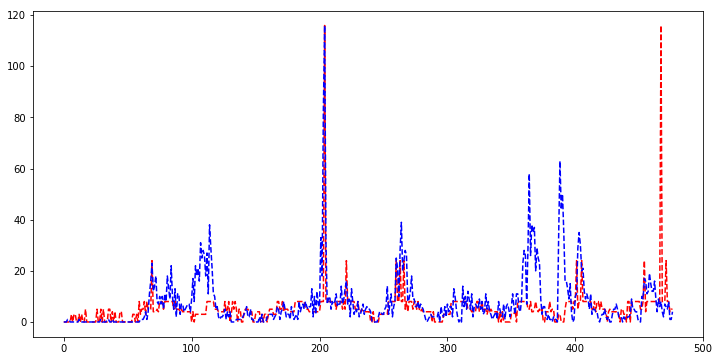

starting grid search
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:   39.1s finished


best params :  {'n_estimators': 20, 'learning_rate': 0.1}
estimator weights :  [ 0.29711376  0.28816895  0.29144961  0.28613314  0.28147914  0.27012311
  0.2692879   0.27217361  0.25384417  0.23184306  0.26538978  0.23439396
  0.27136801  0.24699009  0.24829285  0.21711932  0.24080278  0.24968586
  0.20682605  0.25290931]


In [92]:
iq_dtr = find_best_dtr_params(iq_features_train, iq_labels_train)
test_estimator(iq_dtr, iq_features_train, iq_labels_train)

iq_clf = find_best_boost_params(iq_dtr, iq_features_train, iq_labels_train)


[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    6.9s finished


cross_val scores :  [-6.2875     -5.18067227 -3.87394958 -8.04201681]
mae for val set:  7.31944444444
R2 for val set:  -0.156589497773
mae for train set:  3.87987987988
R2 for train set:  0.586365186942


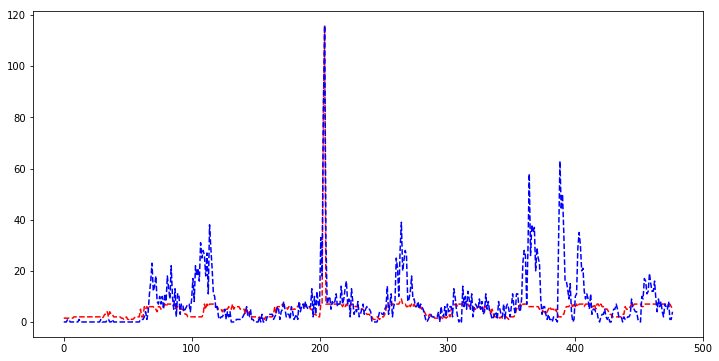

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best'),
         learning_rate=0.1, loss='linear', n_estimators=20, random_state=0)

In [93]:
test_estimator(iq_clf, iq_features_train, iq_labels_train)


num predicted values :  260


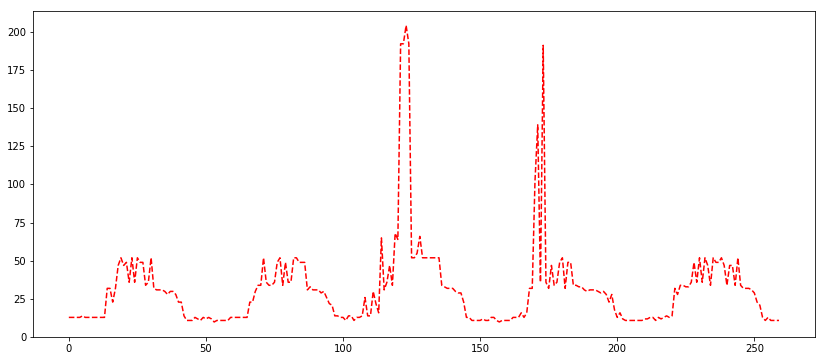

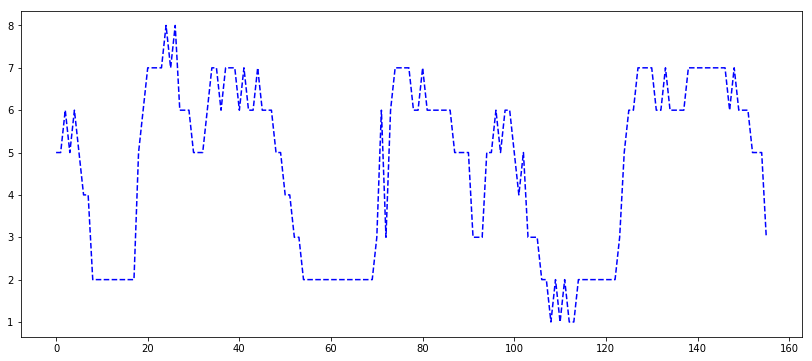

In [94]:
# based on the two estimators for sj and iq, make predictions from
# the competition test data. Start by loading the data
dengue_features_test = pd.read_csv("dengue_features_test.csv", index_col=[0,1,2])
dengue_features_test.drop('week_start_date', axis=1, inplace=True)

# split out the San Juan features and pre process them 
sj_features_test = dengue_features_test.loc['sj']
del sj_features_test['ndvi_ne']

# interpolate missing values - with the test data it doesn't make sense
# to drop entire data rows - so do not limit interpolation
sj_features_test = sj_features_test.interpolate()

# create the time shifted features
time_shifted_features = create_time_shifted_features(sj_features_test, max_history_depth=12, nans_for_unknown=False)
sj_features_test = sj_features_test.join(time_shifted_features)

# now make predictions
sj_predicted_values = sj_clf.predict(sj_features_test)
np.clip(sj_predicted_values, 0, 999999, out=sj_predicted_values)
np.rint(sj_predicted_values, sj_predicted_values)
sj_predicted_values = np.int64(sj_predicted_values)

# repeat for the Iquitos data
iq_features_test = dengue_features_test.loc['iq']
iq_features_test = iq_features_test.interpolate()

time_shifted_features = create_time_shifted_features(iq_features_test, max_history_depth=12, nans_for_unknown=False)
iq_features_test = iq_features_test.join(time_shifted_features)

# now make predictions
iq_predicted_values = iq_clf.predict(iq_features_test)
np.clip(iq_predicted_values, 0, 999999, out=iq_predicted_values)
np.rint(iq_predicted_values, iq_predicted_values)
iq_predicted_values = np.int64(iq_predicted_values)

submission = pd.read_csv("submission_format.csv", index_col=[0, 1, 2])
submission.total_cases = np.concatenate([sj_predicted_values, iq_predicted_values])
submission.to_csv("dengue_predictions_blah.csv")


nrows = len(sj_predicted_values)
print "num predicted values : ", nrows
week = range(0, nrows)
plt.figure(figsize=(14,6))
plt.plot(week, sj_predicted_values, 'r--')
plt.show()

nrows = len(iq_predicted_values)
week = range(0, nrows)
plt.figure(figsize=(14,6))
plt.plot(week, iq_predicted_values, 'b--')
plt.show()


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   15.0s remaining:   45.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   20.5s finished


cross_val scores :  [-30.48198198 -17.38288288  -8.78828829 -42.1036036  -12.51351351
 -11.45945946 -14.65454545 -16.07272727]
mae for val set:  15.6015037594
R2 for val set:  0.22153725021
mae for train set:  16.5193548387
R2 for train set:  0.350366618514


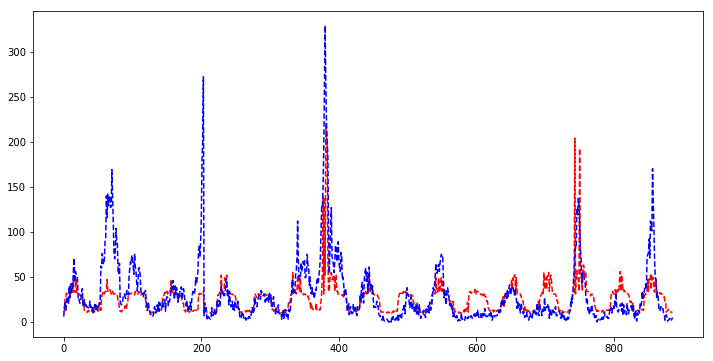

trained feature importances :  [ 0.          0.          0.          0.          0.          0.
  0.07243769  0.00105999  0.          0.00138843  0.00032681  0.00522684
  0.03918105  0.          0.00428239  0.00087643  0.          0.          0.
  0.          0.          0.00302862  0.          0.          0.00044885
  0.          0.          0.          0.          0.          0.          0.0022072
  0.01020358  0.          0.00070809  0.          0.00200917  0.0019272   0.
  0.          0.          0.          0.00597904  0.          0.
  0.00113768  0.          0.00505306  0.          0.          0.00060841
  0.          0.          0.          0.          0.          0.
  0.00338997  0.          0.          0.          0.0017992   0.          0.
  0.00247077  0.          0.00536756  0.          0.00126364  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.00031381  0.          0.          0.          0.          0.
  0.     

In [95]:
    dtr = DecisionTreeRegressor(criterion='mae', max_depth=3, min_samples_split=2, random_state=0)
    boosted = AdaBoostRegressor(base_estimator=dtr, n_estimators=20, learning_rate=0.02, random_state=0)
    trained_est = test_estimator(boosted, sj_features_train, sj_labels_train)
    print "trained feature importances : ", trained_est.feature_importances_

starting grid search
Fitting 8 folds for each of 15 candidates, totalling 120 fits
[CV] n_estimators=10, max_depth=2 ....................................
[CV] ..................... n_estimators=10, max_depth=2, total=   0.1s
[CV] n_estimators=10, max_depth=2 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... n_estimators=10, max_depth=2, total=   0.1s
[CV] n_estimators=10, max_depth=2 ....................................
[CV] ..................... n_estimators=10, max_depth=2, total=   0.1s
[CV] n_estimators=10, max_depth=2 ....................................
[CV] ..................... n_estimators=10, max_depth=2, total=   0.1s
[CV] n_estimators=10, max_depth=2 ....................................
[CV] ..................... n_estimators=10, max_depth=2, total=   0.1s
[CV] n_estimators=10, max_depth=2 ....................................
[CV] ..................... n_estimators=10, max_depth=2, total=   0.1s
[CV] n_estimators=10, max_depth=2 ....................................
[CV] ..................... n_estimators=10, max_depth=2, total=   0.1s
[CV] n_estimators=10, max_depth=2 ....................................
[CV] ..................... n_estimators=10, max_depth=2, total=   0.1s
[CV] n_estimators=20, max_depth=2 ....................................
[CV] .

[CV] ..................... n_estimators=20, max_depth=4, total=   0.5s
[CV] n_estimators=20, max_depth=4 ....................................
[CV] ..................... n_estimators=20, max_depth=4, total=   0.5s
[CV] n_estimators=20, max_depth=4 ....................................
[CV] ..................... n_estimators=20, max_depth=4, total=   0.5s
[CV] n_estimators=20, max_depth=4 ....................................
[CV] ..................... n_estimators=20, max_depth=4, total=   0.5s
[CV] n_estimators=20, max_depth=4 ....................................
[CV] ..................... n_estimators=20, max_depth=4, total=   0.5s
[CV] n_estimators=40, max_depth=4 ....................................
[CV] ..................... n_estimators=40, max_depth=4, total=   1.2s
[CV] n_estimators=40, max_depth=4 ....................................
[CV] ..................... n_estimators=40, max_depth=4, total=   1.1s
[CV] n_estimators=40, max_depth=4 ....................................
[CV] .

[CV] .................... n_estimators=40, max_depth=10, total=   1.9s
[CV] n_estimators=40, max_depth=10 ...................................
[CV] .................... n_estimators=40, max_depth=10, total=   1.8s
[CV] n_estimators=40, max_depth=10 ...................................
[CV] .................... n_estimators=40, max_depth=10, total=   1.8s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.6min finished


best params :  {'n_estimators': 40, 'max_depth': 2}


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.3s remaining:   10.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.2s finished


cross_val scores :  [-34.21970721 -20.20608108  -7.01137387 -43.79155405 -13.45968468
 -12.45664414 -19.61852273 -17.78034091]
mae for val set:  19.2180451128
R2 for val set:  -0.131762165638
mae for train set:  18.8725806452
R2 for train set:  0.0823271206022


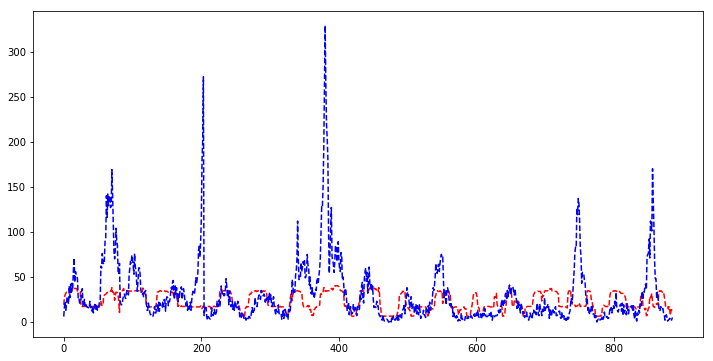

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [96]:
from sklearn.decomposition import PCA

# This section is an attempt to improve the model by controlling overfitting
# by removing unwanted information before trying to fit the model. I also try
# a different ensemble method. It is something of a playground with lots of
# commented out code as I try various things out

pca = PCA(n_components = 20)

# Note that pca.fit happily takes a pandas dataframe, but then returns a numpy array
# Unfortunately I use some features of the dataframe elsewhere - so need to rebuild it
cols = sj_features_train.columns
idx =  sj_features_train.index
reduced_features_train = pd.DataFrame(pca.fit_transform(sj_features_train), index=idx)
#sj_dtr = find_best_dtr_params(reduced_features_train, sj_labels_train)
#test_estimator(sj_dtr, reduced_features_train, sj_labels_train)
#sj_dtr = DecisionTreeRegressor(criterion='mae', max_depth=7, min_samples_split=2, random_state=0)
#sj_clf = find_best_boost_params(sj_dtr, reduced_features_train, sj_labels_train)

nrows = reduced_features_train.shape[0]
years = np.uint32(np.fix(nrows / (52*2)))
crossval = KFold(n_splits = years)
clf = RandomForestRegressor(n_estimators = 50, criterion='mae', max_depth=4, random_state=0)
grid = GridSearchCV(clf, {'n_estimators':[10,20,40], 'max_depth':[2,3,4,6,10]},
                    iid=False, cv=crossval, verbose=1)

# The grid search takes about 3 minutes per parameter combination    
print "starting grid search"
grid.fit(reduced_features_train, sj_labels_train['total_cases'])
print "best params : ", grid.best_params_
    
sj_clf = grid.best_estimator_

#sj_clf = RandomForestRegressor(n_estimators = 50, criterion='mae', max_depth=4, min_samples_split=2, random_state=0)
test_estimator(sj_clf, reduced_features_train, sj_labels_train)

full data rows left :  886
starting grid search
Fitting 8 folds for each of 16 candidates, totalling 128 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 128 out of 128 | elapsed:   27.3s finished


best params :  {'min_samples_split': 2, 'max_depth': 3}
feature_importances :  [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.0s remaining:    9.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.8s finished


cross_val scores :  [-29.88288288 -17.73423423 -12.64414414 -41.72972973 -14.94144144
 -15.28828829 -17.         -21.15909091]
mae for val set:  18.2857142857
R2 for val set:  -0.160432097405
mae for train set:  17.4983870968
R2 for train set:  0.233561412912


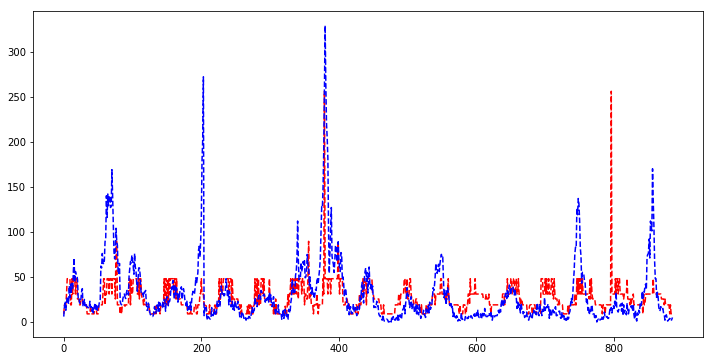

DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [124]:
# In this section I am going to try creating some new features based on exponentials.
# This is an attempt to introduce some domain knowledge into the model.
# First I am going to reduce the original set of features by removing those that
# have a "reanalysis" variant ( and also ndvi_ne, as before due to the large number of missing data ).
# I also remove reanalysis_dew_point_temp_k since this is simply related to temperature and relative humidity.
# and also specific humidity which is also closesly related to relative humidity.
from sklearn.preprocessing import StandardScaler

sj_features_train = dengue_features_train.loc['sj']
sj_labels_train = dengue_labels_train.loc['sj']

drop_features = ['ndvi_ne', 'precipitation_amt_mm', 'station_avg_temp_c',
                 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm',
               'reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg']

sj_features_train = sj_features_train.drop(drop_features, axis=1, inplace=False)

# interpolate missing values - but only for a single week
sj_features_train = sj_features_train.interpolate(limit=1, limit_direction='both')

# create the time shifted features
time_shifted_features = create_time_shifted_features(sj_features_train, max_history_depth=12, nans_for_unknown=True)
sj_features_train_ts = sj_features_train.join(time_shifted_features)

# remove any data rows that are incomplete (ie have missing data)
sj_features_train_ts, sj_labels_train = remove_incomplete_data(sj_features_train_ts, sj_labels_train)
print "full data rows left : ", sj_features_train_ts.shape[0]

# now normalise the data. I do this since the features have values going up to several hundred,
# so exponentiating those will lead to overflows
cols = sj_features_train_ts.columns
idx =  sj_features_train_ts.index
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(sj_features_train_ts), index=idx, columns=cols)

# calc the exponential features and join them on
scaled_features_exp = pd.DataFrame(scaled_features.rpow(2.718))
scaled_features_exp.columns += "_exp"
scaled_features_with_exp = scaled_features.join(scaled_features_exp)

# now train a model on the feature set
sj_dtr = find_best_dtr_params(scaled_features_with_exp, sj_labels_train)
test_estimator(sj_dtr, scaled_features_with_exp, sj_labels_train)


starting grid search
Fitting 8 folds for each of 12 candidates, totalling 96 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  96 out of  96 | elapsed:  4.1min finished


best params :  {'n_estimators': 20, 'learning_rate': 0.02}
estimator weights :  [ 0.05556568  0.05556229  0.05430751  0.0563946   0.05483162  0.05463927
  0.05398147  0.05268157  0.05277092  0.05397693  0.05280667  0.05454294
  0.05356202  0.05287674  0.05325922  0.05331091  0.0514465   0.04979834
  0.04996714  0.05129274]


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   17.2s remaining:   51.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   22.9s finished


cross_val scores :  [-29.33333333 -17.22072072  -8.8018018  -41.07207207 -13.48198198
 -12.11711712 -15.55454545 -16.42272727]
mae for val set:  16.8082706767
R2 for val set:  0.157824587226
mae for train set:  17.1419354839
R2 for train set:  0.204121850891


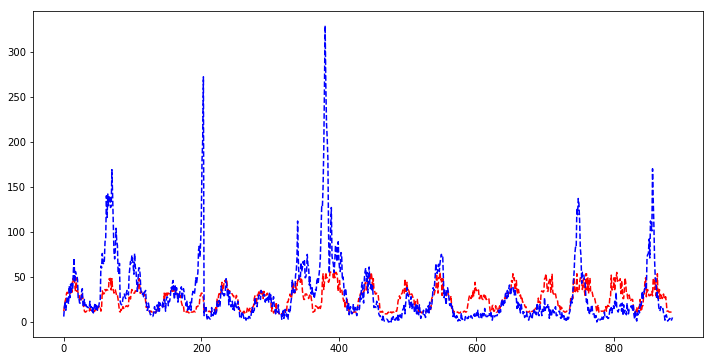

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best'),
         learning_rate=0.02, loss='linear', n_estimators=20,
         random_state=0)

In [125]:
sj_clf = find_best_boost_params(sj_dtr, scaled_features_with_exp, sj_labels_train)
test_estimator(sj_clf, scaled_features_with_exp, sj_labels_train)
